# Bayesian Linear Regression

In [11]:
import numpy as np
from numpy.random import multivariate_normal
from scipy.stats import multivariate_normal as m_norm
from scipy.stats import norm
from numpy.random import normal
from data import load_data
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [12]:
X, y = load_data("weatherHistory.csv", "\n", ",", target_col=4, numeric_target=True, ignore_cols=[0,1,2,3,6,7,8,9,11])

Model can be defined as:
\begin{align}
y & = X^{T}\theta + \varepsilon \\
\varepsilon & \sim \mathcal{N}(0,\sigma^{2}) \\
\theta & \sim \mathcal{N}(m_{0},S_{0})
\end{align}

In [13]:
N,M = X.shape

# Parameters for prior on weight
m0 = np.random.random([M,1])
S0 = np.random.random([M,M])

In [14]:
# Noise variance
var = 0.1

Posterior distribution over target variable can be predicted by:

\begin{align}
p(y_{*}|X,y,x_{*}) & = \int p(y_{*}|x_{*},\theta) p(\theta|X,y) d\theta \\
& = \int \mathcal{N}(y_{*}|X^{T}\theta,\sigma^{2}) \mathcal{N}(\theta|m_{N},S_{N}) d\theta
\end{align}

But there is a problem, we do not yet have $m_{N},S_{N}$ In order to compute these, we first transform posterior, which is defined as: 

\begin{align}
p(\theta|X,y) = p(y|X,\theta)p(\theta)
\end{align}

into log space, where we sum them and solve for these parameters using a procedure called "Complete the squares". 
PS: Normalisation constant in posterior is omitted to keep things simple. The result after performing completing squares would be:

\begin{align}
S_{N} & = (\sigma^{-2}X^{T}X + S_{0}^{-1})^{-1} \\
m_{N} & = S_{N}(\sigma^{-2}X^{T}y + S_{0}^{-1}m_{0})
\end{align}

In [15]:
# Posterior parameters

SN = np.linalg.inv(1/var * (X.T @ X) + np.linalg.inv(S0))
mN = SN @ (1/var * (X.T @ y).reshape([-1,1]) + (np.linalg.inv(S0) @ m0))

In [16]:
# MLE estimate

W_mle = np.linalg.inv(X.T @ X) @ X.T @ y

In [17]:
# Compare the mean parameter with MLE estimate

print("\nW_mle: \n{}\n".format(W_mle))
print("mN: \n{}\n".format(mN.ravel()))


W_mle: 
[-21.13877638   0.02760129]

mN: 
[-21.14721152   0.02760738]



In [18]:
def plot(N_samples=400):

    # Now, lets sample parameters from posterior distribution
    W = multivariate_normal(mean=mN.ravel(), cov=SN, size=[N_samples])
    # W_density = np.zeros([N_samples,2])
    # W_density[:,0] = norm.pdf(x=W[:,0], loc=mN[0,0], scale=SN[0,0])
    # W_density[:,1] = norm.pdf(x=W[:,1], loc=mN[1,0], scale=SN[1,1])
    
    # Humidities constribution
    plt.figure()
    plt.xlabel("Contribution of Humidity to Apparent Temperature")
    plt.ylabel("Frequency")
    plt.hist(W[:,0],bins=30,rwidth=0.9)
    # plt.bar(x=W[:,0],height=sample)
    plt.axvline(x=mN[0,0],color="red",linestyle="--")
    
    # Pressure contribution
    plt.figure()
    plt.xlabel("Contribution of Pressure to Apparent Temperature")
    plt.ylabel("Frequency")
    plt.hist(W[:,1],bins=30,rwidth=0.9)
    # plt.bar(x=W[:,0],height=sample)
    plt.axvline(x=mN[1,0],color="red",linestyle="--")
    plt.show()

In [19]:
interact(plot, x=widgets.IntSlider(min=300,max=1000));

interactive(children=(IntSlider(value=400, description='N_samples', max=1200, min=-400), Output()), _dom_class…

We are now equipped with necessary information to proceed with predicting $y$. We defined posterior distribution over test target, given test input

\begin{align}
\mathop{\mathbb{E}_{\theta,\varepsilon}}[y_{*}|X,y,x_{*}] & = \mathop{\mathbb{E}_{\theta}}[X^{T}\theta|X,y] \\
& = x_{*}^{T}\mathop{\mathbb{E}_{\theta}}[\theta|X,y] + 0 \\
& = x_{*}^{T}m_{N}
\end{align}

\begin{align}
\mathrm{Var}_{\theta,\varepsilon}[y_{*}|X,y,x_{*}] & = \mathrm{Var}_{\theta,\varepsilon}[x_{*}^{T}\theta+\varepsilon|X,y] \\
& = x_{*}^{T}\mathrm{Var}_{\theta}[\theta|X,y]x_{*} + \sigma^{2} \\
& = x_{*}^{T}S_{N}x_{*} + \sigma^{2}
\end{align}

\begin{align}
p(y_{*}|X,y,x_{*}) & = \int p(y_{*}|x_{*},\theta) p(\theta|X,y) d\theta \\
& = \int \mathcal{N}(y_{*}|X^{T}\theta,\sigma^{2}) \mathcal{N}(\theta|m_{N},S_{N}) d\theta \\
& = \mathcal{N}(y_{*}|x_{*}^{T}m_{N},x_{*}^{T}S_{N}x_{*} + \sigma^{2})
\end{align}

13.248507304495213


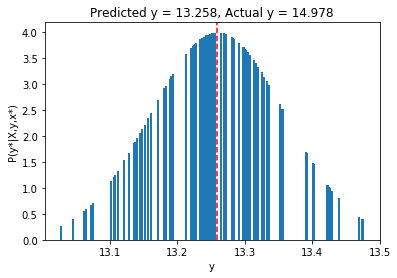

In [20]:
test_index = np.random.randint(0,N)
test_x = X[test_index]
test_y = y[test_index]

test_mean = test_x.T @ mN
test_var = (test_x.T @ SN @ test_x) + var
y_samples = normal(loc=test_mean, scale=test_var, size=[100])
print(np.mean(y_samples))
y_density = norm.pdf(x=y_samples, loc=test_mean, scale=test_var)
plt.figure()
plt.title("Predicted y = %.3f, Actual y = %.3f"%(test_mean,test_y))
plt.xlabel("y")
plt.ylabel("P(y*|X,y,x*)")
plt.bar(y_samples, height=y_density, align='edge', width=0.003)
plt.axvline(x=test_mean, color="red", linestyle="--")
plt.show()

0.10000834087820078